In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
import GO_utils
import utils
from os import listdir
from os.path import isfile, join

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Functions for Obtaining Experiment Results
# TODO: results w/out log-transforming the expression levels

In [4]:
def get_prediction_results(results_dir):
    #results_dir = '../../../../Downloads/results_server_3'
    results_files = [f for f in listdir(results_dir) if isfile(join(results_dir, f))]

    GO_terms = {}
    roc_auc_scores = []
    roc_auc_score_line = 2
    for rf in results_files:
        f = open(results_dir + '/' + rf)
        GO_term = None
        labels = []
        preds = []
        for (i, line) in enumerate(f):
            if i == 0:
                GO_term = line.rstrip().split(' ')[-1]
            elif i == roc_auc_score_line:
                vals = line.rstrip().split(' ')
                roc_auc_scores.append(float(vals[-1]))
            elif line[0:4] == 'ENSG':
                vals = line.rstrip().split('\t')
                labels.append(int(vals[1]))
                preds.append(int(vals[2]))
        GO_terms[GO_term] = (labels, preds)
    return GO_terms, roc_auc_scores

def get_GO_gene_cnts():
    cnts_file = open('../data/GO_terms_final_gene_counts.txt')
    GO_to_num_genes = {}
    for (i, line) in enumerate(cnts_file):
        if i < 2:
            continue
        vals = line.rstrip().split('\t')
        GO_id = vals[0]
        num_genes = int(vals[1])
        GO_to_num_genes[GO_id] = num_genes
    return GO_to_num_genes
        

## Results after Using Log Transformed Expression Profiles

In [5]:
lt_GO_terms, lt_roc_aucs = get_prediction_results('results_log_transformed_0')
lt_GO_terms_rand, lt_roc_aucs_rand = get_prediction_results('results_log_transformed_rand_perm_0')

## Summarize the ROC AUC Scores

Mean ROC AUC:  0.611865063819
Mean ROC AUC when labels randomly permuted:  0.496874399021


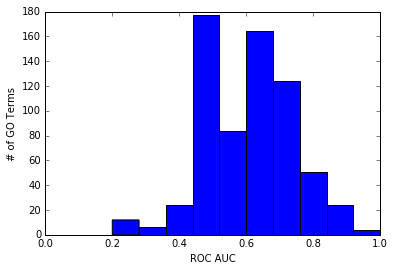

In [6]:
print 'Mean ROC AUC: ', np.mean(lt_roc_aucs)
print 'Mean ROC AUC when labels randomly permuted: ', np.mean(lt_roc_aucs_rand)

plt.hist(lt_roc_aucs)
plt.xlim([0.0, 1.0])
plt.xlabel('ROC AUC')
plt.ylabel('# of GO Terms')
plt.show()

(0.0, 1.0)

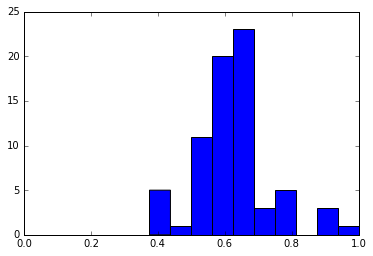

In [18]:
# Old (server 0)
plt.hist(roc_auc_scores)
plt.xlim([0.0, 1.0])

## Plot ROC Curves

In [9]:
def plot_roc(fprs, tprs, title):
    plt.figure()
    for (fpr, tpr) in zip(fprs, tprs):
        plt.plot(fpr, tpr, 'gray')
    plt.plot([0, 1], [0, 1], 'k--')  # Plot the 50% line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
    
def plot_roc_heat(fprs, tprs, gene_cnts, title):
 
    NCURVES = len(gene_cnts)
    xs = fprs

    fig = plt.figure()
    ax = fig.add_subplot(111)

    cmap = plt.cm.YlOrRd
    min_count = int(min(gene_cnts))
    max_count = int(max(gene_cnts))
    scalarMap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_count, vmax=max_count))

    for idx in range(NCURVES):
        colorVal = scalarMap.to_rgba(gene_cnts[idx])
        ax.plot(fprs[idx], tprs[idx], color=colorVal)
        
    #ax.plot([0, 1], [0, 1], 'black')  # Plot the 50% line       

    # Generate colorbar
    scalarMap.set_array([])  # You have to set a dummy-array for this to work...
    cbar = plt.colorbar(scalarMap)
    cbar.set_label('# of Genes')
    #cbar.set_ticks(gene_cnts)
    #cbar.set_ticklabels(['{:4.1f}'.format(yi) for yi in y]) # Make 'em nicer-looking

    ax.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()
    
def make_roc_curves(GO_terms_map, GO_cnts):
    false_pos_rates = []
    true_pos_rates = []
    GO_terms_list = GO_terms_map.keys()
    gene_counts = [GO_cnts[term] for term in GO_terms_list]
    sorted_tuples = sorted(zip(GO_terms_list, gene_counts), key=lambda tup: tup[1], reverse=False)
    GO_terms_list = [tup[0] for tup in sorted_tuples]
    gene_counts = [tup[1] for tup in sorted_tuples]
    for term in GO_terms_list:
        (cur_labels, cur_preds) = GO_terms_map[term]
        cur_fpr, cur_tpr, _ = roc_curve(cur_labels, cur_preds)
        false_pos_rates.append(cur_fpr)
        true_pos_rates.append(cur_tpr)

    plot_roc(false_pos_rates, true_pos_rates, 'ROC for Log Transformed Expressions')
    plot_roc_heat(false_pos_rates, true_pos_rates, gene_counts, 'ROC for Log Transformed Expressions')

## ROC Curves for Log Transformed Expressions (No random permutations)

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


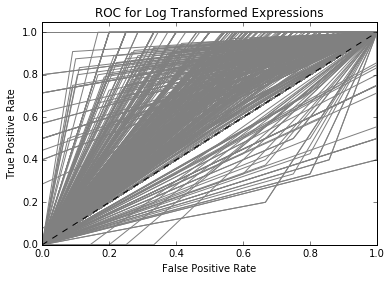

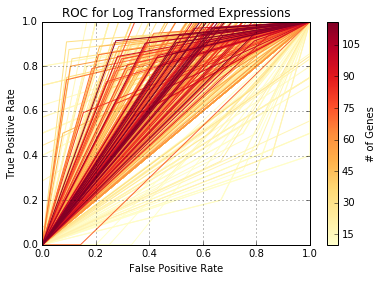

In [10]:
GO_counts = get_GO_gene_cnts()
make_roc_curves(lt_GO_terms, GO_counts)

## ROC Curves for Log Transformed Expressions (with randomly permuted labels)

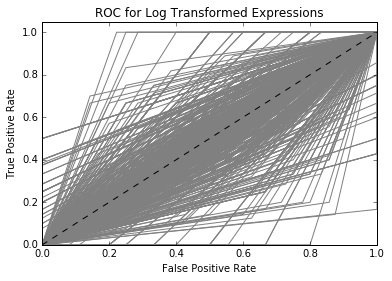

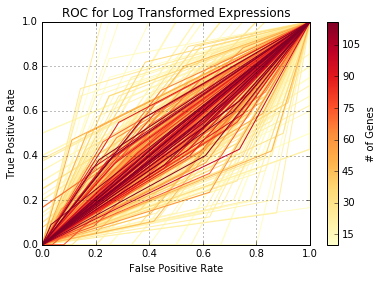

In [11]:
make_roc_curves(lt_GO_terms_rand, GO_counts)

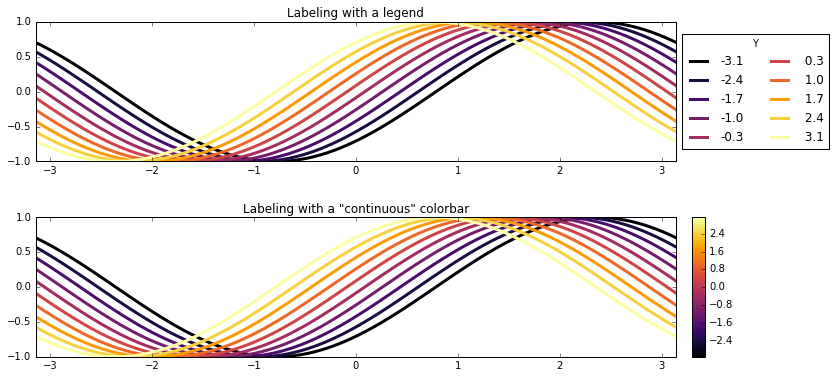

In [149]:
# Use the spectral colormap for examples
cmap = plt.cm.inferno

# Generate some fake data
N = 100
nlines = 10
x = np.linspace(-np.pi, np.pi, N) 
y = np.linspace(-np.pi, np.pi, nlines)

# Use np.newaxis to create [N,1] and [1,Nlines] x and y arrays
# Then broadcasting to generate Z with shape [N,Nlines]
z = np.sin(x[:,np.newaxis] + y[np.newaxis,:]/4)

# Use 0-1 values to generate the colors with the linspace method
line_colors = cmap(np.linspace(0,1,nlines))

# We have to generate our own axis to put the colorbar in
# otherwise it "steals" space from the current axis.  Please
# let me know if anyone has found another way around this,
# because the custom axes generation is the only way I've
# figured out.
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize = (12,6))
nrows = 2
gs = GridSpec(nrows,2,width_ratios=[50,1])
ax = [plt.subplot(gs[i,0]) for i in range(nrows)]
cbax1 = plt.subplot(gs[1,1])

# First, plot lines w/ legend
a = ax[0]
a.set_title('Labeling with a legend')

for i in range(nlines):
    a.plot(x, z[:,i], c=line_colors[i],lw=3,label='{:4.1f}'.format(y[i]))
leg = a.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
leg.set_title('Y')

# Next, plot with colorbar
a = ax[1]
a.set_title('Labeling with a "continuous" colorbar')

for i in range(nlines):
    a.plot(x, z[:,i], c=line_colors[i],lw=3,label='{:3.1f}'.format(y[i]))

# Generate fake ScalarMappable for colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=y[0],vmax=y[-1]))
sm.set_array([])  # You have to set a dummy-array for this to work...
cbar = plt.colorbar(sm, cax=cbax1)
#cbar.set_label('Y')
#cbar.set_ticks(y)
#cbar.set_ticklabels(['{:4.1f}'.format(yi) for yi in y]) # Make 'em nicer-looking

# Moves colorbar closer to main axis by adjusting width-spacing between subplot axes.
fig.subplots_adjust(wspace=0.05, hspace=0.4)

# Set axis limits
for a in ax:
    a.set_xlim(-np.pi, np.pi)